In [1]:
import matplotlib.pyplot as plt
import io
import fitz
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
from IPython.display import display
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from catalogue import collect_catalogue_from_ATNF

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_20 = 'outdir_20_percent_threshold'
outdir_50 = 'outdir_50_percent_error'
outdir_aic = 'outdir_aic'
outdir_aw = 'outdir_aic_without'

In [2]:
no_best_fit = ['J0511-6508', 'J0517+2212', 'J0536-7543', 'J0656-2228', 'J0711+0931', 'J0751+1807', 'J0834-4159', 'J0842-4851', 'J0901-4624', 'J1020-6026', 'J1028-5819', 'J1043-6116', 'J1052-5954', 'J1114-6100', 'J1126-6054', 'J1126-6942', 'J1302-6350', 'J1305-6203', 'J1357-6429', 'J1410-7404', 'J1420-6048', 'J1513-5739', 'J1534-5334', 'J1535-4114', 'J1626-4807', 'J1632-4757', 'J1636-4440', 'J1637-4642', 'J1638-4608', 'J1650-4502', 'J1652+2651', 'J1717-4054', 'J1727-2739', 'J1734-3333', 'J1735-3258', 'J1740+1000', 'J1747-2958', 'J1751-3323', 'J1758+3030', 'J1803-2137', 'J1804-0735', 'J1804-2717', 'J1806-2125', 'J1809-1917', 'J1812+0226', 'J1815-1738', 'J1816-1729', 'J1819+1305', 'J1820-1529', 'J1822-1400', 'J1824-2452A', 'J1825-1446', 'J1832-1021', 'J1837-0045', 'J1847-0438', 'J1852+0031', 'J1903+0327', 'J1910+0714', 'J1910+1231', 'J1914+1122', 'J1918+1444', 'J1921+1419', 'J2002+1637', 'J2008+2513', 'J2013+3845', 'J2038-3816', 'J2234+0611', 'J2307+2225']
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
print(f'Number of pulsars in the catalogue: {len(catalogue)}')
for n in range(4, 7):
    print(f'Number of pulsars with {n} or more flux density measurements: {len(catalogue.at_least_n_points(n))}')
    
def load_results(outdir: str, aic: bool = False):
    var = 'aic' if aic else 'log_evidence'
    with open(f'../output/results_param_estimates_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        param_est = json.load(f)
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.idxmin(axis=1) if aic else results.idxmax(axis=1)
        # Remove bad fits
        results.loc[no_best_fit, 'best_fitting'] = '(Unclassified)'
    return results, param_est
results_10, param_est_10 = load_results(outdir_10)
results_20, param_est_20 = load_results(outdir_20)
results_50, param_est_50 = load_results(outdir_50)
results_aic, param_est_aic = load_results(outdir_aic, aic=True)
results_aw, param_est_aw = load_results(outdir_aw, aic=True)

print(f'Number of pulsars reaching requirements for fitting: {len(results_10)}')
print('(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)')

Number of pulsars in the catalogue: 3345
Number of pulsars with 4 or more flux density measurements: 1655
Number of pulsars with 5 or more flux density measurements: 1593
Number of pulsars with 6 or more flux density measurements: 1519
Number of pulsars reaching requirements for fitting: 876
(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)


Best-fitting classification by the four methods:


,Model,10% threshold,20% threshold,50% error,Corrected AIC,AIC
0,log-parabolic spectrum,385 / 876 (43.9%),432 / 876 (49.3%),487 / 876 (55.6%),179 / 876 (20.4%),175 / 876 (20.0%)
1,broken power law,269 / 876 (30.7%),211 / 876 (24.1%),144 / 876 (16.4%),259 / 876 (29.6%),323 / 876 (36.9%)
2,low-frequency turn-over power law,79 / 876 (9.0%),90 / 876 (10.3%),102 / 876 (11.6%),51 / 876 (5.8%),60 / 876 (6.8%)
3,simple power law,38 / 876 (4.3%),46 / 876 (5.3%),57 / 876 (6.5%),208 / 876 (23.7%),131 / 876 (15.0%)
4,high-frequency cut-off power law,37 / 876 (4.2%),29 / 876 (3.3%),18 / 876 (2.1%),111 / 876 (12.7%),119 / 876 (13.6%)
5,(Unclassified),68 / 876 (7.8%),68 / 876 (7.8%),68 / 876 (7.8%),68 / 876 (7.8%),68 / 876 (7.8%)


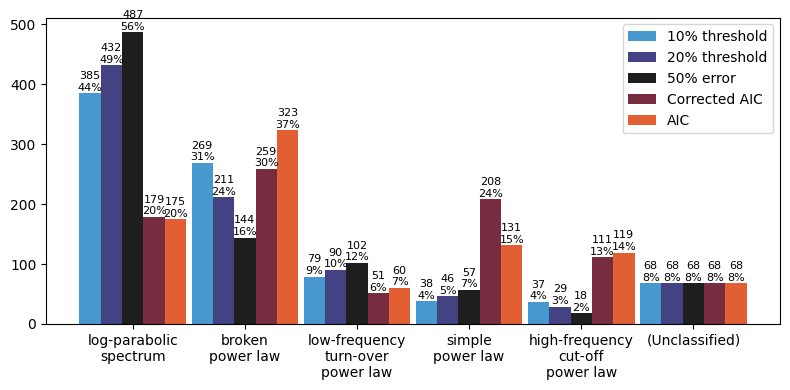

In [3]:
print('Best-fitting classification by the four methods:')

def model_name_cap(model_name: str | np.ndarray):
    if isinstance(model_name, np.ndarray):
        return np.array([model_name_cap(m) for m in model_name])
    return model_name.replace('_', ' ').replace('g ', 'g-').replace(' f', '-f').replace(' o', '-o')
def model_name_br(model_name: str | np.ndarray):
    if isinstance(model_name, np.ndarray):
        return np.array([model_name_br(m) for m in model_name])
    return model_name_cap(model_name).replace(' ', '\n').replace('r\nl', 'r l')

x_10 = results_10['best_fitting'].value_counts().index.to_numpy()
y_10 = results_10['best_fitting'].value_counts().to_numpy()
x_20 = results_20['best_fitting'].value_counts().index.to_numpy()
y_20 = results_20['best_fitting'].value_counts().to_numpy()
x_50 = results_50['best_fitting'].value_counts().index.to_numpy()
y_50 = results_50['best_fitting'].value_counts().to_numpy()
x_aic = results_aic['best_fitting'].value_counts().index.to_numpy()
y_aic = results_aic['best_fitting'].value_counts().to_numpy()
x_aw = results_aw['best_fitting'].value_counts().index.to_numpy()
y_aw = results_aw['best_fitting'].value_counts().to_numpy()

# move unclassified to the end
idx = np.where(x_10 == '(Unclassified)')[0][0]
x_10 = np.concatenate([x_10[:idx], x_10[idx+1:], [x_10[idx]]])
y_10 = np.concatenate([y_10[:idx], y_10[idx+1:], [y_10[idx]]])

# sort by x_10
x_20, y_20 = zip(*sorted(zip(x_20, y_20), key=lambda x: x_10.tolist().index(x[0])))
x_50, y_50 = zip(*sorted(zip(x_50, y_50), key=lambda x: x_10.tolist().index(x[0])))
x_aic, y_aic = zip(*sorted(zip(x_aic, y_aic), key=lambda x: x_10.tolist().index(x[0])))
x_aw, y_aw = zip(*sorted(zip(x_aw, y_aw), key=lambda x: x_10.tolist().index(x[0])))

display(pd.DataFrame({
    'Model': model_name_cap(x_10),
    '10% threshold': [f'{v} / {np.sum(y_10)} ({v/np.sum(y_10)*100:.1f}%)' for v in y_10],
    '20% threshold': [f'{v} / {np.sum(y_20)} ({v/np.sum(y_20)*100:.1f}%)' for v in y_20],
    '50% error': [f'{v} / {np.sum(y_50)} ({v/np.sum(y_50)*100:.1f}%)' for v in y_50],
    'Corrected AIC': [f'{v} / {np.sum(y_aic)} ({v/np.sum(y_aic)*100:.1f}%)' for v in y_aic],
    'AIC': [f'{v} / {np.sum(y_aw)} ({v/np.sum(y_aw)*100:.1f}%)' for v in y_aw]
}))

fig, ax = plt.subplots(figsize=(8, 4))

bar_width = 0.19
bar_positions = np.arange(len(x_10))

colors = sns.color_palette('icefire', 5)
ax.bar(bar_positions - bar_width * 2., y_10, bar_width, label='10% threshold', color=colors[0])
ax.bar(bar_positions - bar_width * 1., y_20, bar_width, label='20% threshold', color=colors[1])
ax.bar(bar_positions, y_50, bar_width, label='50% error', color=colors[2])
ax.bar(bar_positions + bar_width * 1., y_aic, bar_width, label='Corrected AIC', color=colors[3])
ax.bar(bar_positions + bar_width * 2., y_aw, bar_width, label='AIC', color=colors[4])
labels_10 = [f'{v}\n{v/np.sum(y_10)*100:.0f}%' for v in y_10]
labels_20 = [f'{v}\n{v/np.sum(y_20)*100:.0f}%' for v in y_20]
labels_50 = [f'{v}\n{v/np.sum(y_50)*100:.0f}%' for v in y_50]
labels_aic = [f'{v}\n{v/np.sum(y_aic)*100:.0f}%' for v in y_aic]
labels_aw = [f'{v}\n{v/np.sum(y_aw)*100:.0f}%' for v in y_aw]
for i, (label_10, label_20, label_50, label_aic, label_aw) in enumerate(zip(labels_10, labels_20, labels_50, labels_aic, labels_aw)):
    ax.text(i - bar_width * 2., y_10[i] + 1, label_10, ha='center', va='bottom', fontsize=8)
    ax.text(i - bar_width * 1., y_20[i] + 1, label_20, ha='center', va='bottom', fontsize=8)
    ax.text(i, y_50[i] + 1, label_50, ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width * 1., y_aic[i] + 1, label_aic, ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width * 2., y_aw[i] + 1, label_aw, ha='center', va='bottom', fontsize=8)

ax.set_xticks(bar_positions)
ax.set_xticklabels(model_name_br(x_10))
ax.legend()
plt.tight_layout()
plt.show()

In [4]:
# drop bad fits
results_10 = results_10.drop(index=no_best_fit)
results_20 = results_20.drop(index=no_best_fit)
results_50 = results_50.drop(index=no_best_fit)
results_aic = results_aic.drop(index=no_best_fit)
results_aw = results_aw.drop(index=no_best_fit)

print('Ln Bayes factors greater than 5 (versus simple power law):')

results_10_bf = results_10.drop(columns='best_fitting').sub(results_10['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_20_bf = results_20.drop(columns='best_fitting').sub(results_20['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_50_bf = results_50.drop(columns='best_fitting').sub(results_50['simple_power_law'], axis=0).drop(columns='simple_power_law')

results_bf_gt5 = pd.DataFrame({
    '10% threshold': (results_10_bf > 5).sum(),
    '20% threshold': (results_20_bf > 5).sum(),
    '50% error': (results_50_bf > 5).sum()
})
# sort by 10% threshold
results_bf_gt5 = results_bf_gt5.loc[results_bf_gt5['10% threshold'].sort_values(ascending=False).index]

results_bf_gt5.loc['(Any ln BF > 5)'] = [
    (results_10_bf > 5).any(axis=1).sum(),
    (results_20_bf > 5).any(axis=1).sum(),
    (results_50_bf > 5).any(axis=1).sum()
]
results_bf_gt5.loc['(All ln BF < -5)'] = [
    (results_10_bf < -5).all(axis=1).sum(),
    (results_20_bf < -5).all(axis=1).sum(),
    (results_50_bf < -5).all(axis=1).sum()
]

# change the values to {} / {} = {}% format
results_bf_gt5 = results_bf_gt5.applymap(lambda x: f'{x:d} / {len(results_10)} ({x/len(results_10)*100:.1f}%)')

results_bf_gt5

Ln Bayes factors greater than 5 (versus simple power law):


,10% threshold,20% threshold,50% error
log_parabolic_spectrum,357 / 808 (44.2%),276 / 808 (34.2%),171 / 808 (21.2%)
broken_power_law,338 / 808 (41.8%),249 / 808 (30.8%),140 / 808 (17.3%)
low_frequency_turn_over_power_law,277 / 808 (34.3%),210 / 808 (26.0%),142 / 808 (17.6%)
high_frequency_cut_off_power_law,209 / 808 (25.9%),128 / 808 (15.8%),71 / 808 (8.8%)
(Any ln BF > 5),398 / 808 (49.3%),315 / 808 (39.0%),187 / 808 (23.1%)
(All ln BF < -5),0 / 808 (0.0%),0 / 808 (0.0%),0 / 808 (0.0%)


Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:
Without systematic error:
Number of points: 716
Number of outliers: 48


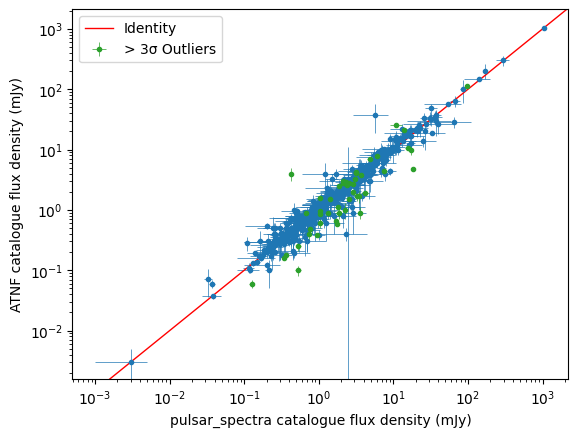

With systematic error:
Number of points: 716
Number of outliers: 18


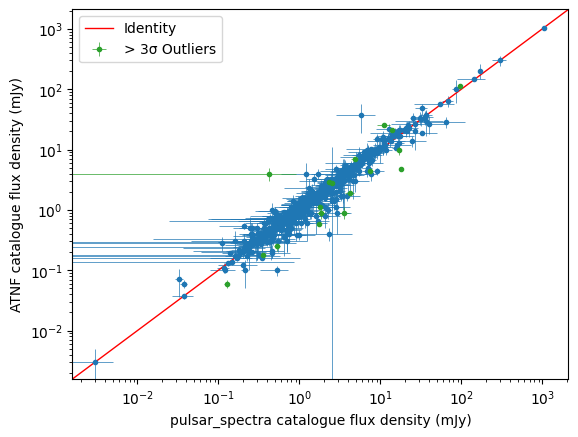

In [5]:
jname_list = list(param_est_10.keys())
atnf_latest_cat = collect_catalogue_from_ATNF(jname_list, atnf_ver='latest')

print('Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:')

central_freq = 1400.
pul_cat_Ys = []
pul_cat_YERRs = []
pul_cat_YERRs_mod = []
atnf_Ys = []
atnf_YERRs = []

for jname in results_10.index:
    if jname not in atnf_latest_cat.cat_dict:
        continue
    if jname not in param_est_10:
        continue
    if jname in no_best_fit:
        continue
    
    pul_cat_Y_in_range = []
    pul_cat_YERR_in_range = []
    for i, freq in enumerate(catalogue.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            pul_cat_Y_in_range.append(catalogue.cat_dict[jname]['Y'][i])
            pul_cat_YERR_in_range.append(catalogue.cat_dict[jname]['YERR'][i])
            
    if len(pul_cat_Y_in_range) < 1:
        continue
        
    atnf_Y_in_range = []
    atnf_YERR_in_range = []
    for i, freq in enumerate(atnf_latest_cat.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            atnf_Y_in_range.append(atnf_latest_cat.cat_dict[jname]['Y'][i])
            atnf_YERR_in_range.append(atnf_latest_cat.cat_dict[jname]['YERR'][i])
                
    if len(atnf_Y_in_range) < 1:
        continue
        
    if len(pul_cat_Y_in_range) > 1:
        pul_cat_Y_in_range = np.array(pul_cat_Y_in_range)
        pul_cat_YERR_in_range = np.array(pul_cat_YERR_in_range)
        
        # Best model
        best_model = results_10.loc[jname, 'best_fitting']
        sigma = param_est_10[jname][best_model]['median'][-1]
        # add sigma to the errors that are less than 10% of the flux
        pul_cat_10_percent = np.where(pul_cat_YERR_in_range < 0.1 * pul_cat_Y_in_range)
        pul_cat_YERR_mod_in_range = np.copy(pul_cat_YERR_in_range)
        pul_cat_YERR_mod_in_range[pul_cat_10_percent] = np.sqrt(pul_cat_YERR_in_range[pul_cat_10_percent] ** 2 + sigma ** 2)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        pul_cat_Y = np.median(pul_cat_Y_in_range)
        pul_cat_YERR = pul_cat_YERR_in_range[np.argmin(np.abs(pul_cat_Y_in_range - pul_cat_Y))]
        pul_cat_YERR_mod = pul_cat_YERR_mod_in_range[np.argmin(np.abs(pul_cat_Y_in_range - pul_cat_Y))]
        
    else:
        pul_cat_Y = pul_cat_Y_in_range[0]
        pul_cat_YERR = pul_cat_YERR_in_range[0]
        pul_cat_YERR_mod = pul_cat_YERR_in_range[0]
        
    if len(atnf_Y_in_range) > 1:
        atnf_Y_in_range = np.array(atnf_Y_in_range)
        atnf_YERR_in_range = np.array(atnf_YERR_in_range)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        atnf_Y = np.median(atnf_Y_in_range)
        atnf_YERR = atnf_YERR_in_range[np.argmin(np.abs(atnf_Y_in_range - atnf_Y))]
        
    else:
        atnf_Y = atnf_Y_in_range[0]
        atnf_YERR = atnf_YERR_in_range[0]
        
    pul_cat_Ys.append(pul_cat_Y)
    pul_cat_YERRs.append(pul_cat_YERR)
    pul_cat_YERRs_mod.append(pul_cat_YERR_mod)
    atnf_Ys.append(atnf_Y)
    atnf_YERRs.append(atnf_YERR)
        
def draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, title: str):
    # Group the data by outliers (> 3 sigma) and inliers
    pul_cat_Ys = np.array(pul_cat_Ys)
    pul_cat_YERRs = np.array(pul_cat_YERRs)
    atnf_Ys = np.array(atnf_Ys)
    atnf_YERRs = np.array(atnf_YERRs)
    
    outliers = np.abs(pul_cat_Ys - atnf_Ys) > 3 * np.sqrt(pul_cat_YERRs ** 2 + atnf_YERRs ** 2)
    pul_cat_Ys_outliers = pul_cat_Ys[outliers]
    pul_cat_YERRs_outliers = pul_cat_YERRs[outliers]
    atnf_Ys_outliers = atnf_Ys[outliers]
    atnf_YERRs_outliers = atnf_YERRs[outliers]
    
    print(f'Number of points: {len(pul_cat_Ys)}')
    print(f'Number of outliers: {len(pul_cat_Ys_outliers)}')
    
    pul_cat_Ys_inliers = pul_cat_Ys[~outliers]
    pul_cat_YERRs_inliers = pul_cat_YERRs[~outliers]
    atnf_Ys_inliers = atnf_Ys[~outliers]
    atnf_YERRs_inliers = atnf_YERRs[~outliers]
            
    # Draw a scatter plot
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(pul_cat_Ys_inliers, atnf_Ys_inliers, xerr=pul_cat_YERRs_inliers, yerr=atnf_YERRs_inliers, fmt='o', elinewidth=0.5, color='tab:blue', markersize=3)
    plt.errorbar(pul_cat_Ys_outliers, atnf_Ys_outliers, xerr=pul_cat_YERRs_outliers, yerr=atnf_YERRs_outliers, fmt='o', label='> 3σ Outliers', elinewidth=0.5, color='tab:green', markersize=3)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([0, 1e4], [0, 1e4], 'r-', label='Identity', linewidth=1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('pulsar_spectra catalogue flux density (mJy)')
    plt.ylabel('ATNF catalogue flux density (mJy)')
    plt.legend()
    plt.savefig(title + '.pdf', bbox_inches='tight')
    plt.show()

print('Without systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, 'Flux density comparison with ATNF catalogue (without systematic error)')
print('With systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs_mod, atnf_Ys, atnf_YERRs, 'Flux density comparison with ATNF catalogue (with systematic error)')